# **Анализ тональности отзывов из интернета**

В рамках данной работы будет выбрана оптимальная модель классификации отзывов из интернета на русском языке. Будут рассмотрены классические алгоритмы ML и предобученная нейросеть.

# Setup

In [ ]:
! pip3 install nltk

In [ ]:
!pip3 install kaggle --upgrade
!pip3 install pandas --upgrade
# !mkdir /Users/yaseminkhertek/.kaggle
!cp ../config/kaggle.json /Users/yaseminkhertek/.kaggle/kaggle.json
!chmod 600 /Users/yaseminkhertek/.kaggle/kaggle.json

In [ ]:
# скачивание датасета (указать dataset name)
import kaggle

dataset_urls = ["https://www.kaggle.com/datasets/dineshpiyasamara/sentiment-analysis-dataset",
                "https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset",
                "https://www.kaggle.com/datasets/mar1mba/russian-sentiment-dataset"]

dataset_names = [url.replace('https://www.kaggle.com/datasets/', '') for url in dataset_urls]

kaggle.api.authenticate()

for dataset_name in dataset_names:
  kaggle.api.dataset_download_files(
      dataset_name,
      unzip=True)

# Начало

In [76]:
import pandas as pd
import numpy as np
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import pickle 

pd.set_option('display.max_columns', None)

## ru dataset
- Overview
> This dataset is a comprehensive collection of Russian-language reviews and texts annotated for sentiment analysis. It is designed to support the development and evaluation of sentiment analysis models for the Russian language. The dataset is **balanced** across sentiment classes (neutral, positive, and negative) to ensure fair model training and evaluation.

- Dataset Composition
> The dataset is compiled from multiple publicly available sources.
All source datasets were carefully balanced across sentiment classes (neutral, positive, and negative) to ensure a robust and unbiased dataset.

- Dataset Structure
> The dataset contains the following columns:

  - text: The text of the review or comment.
  - label: The sentiment label, where:
    - 0: Neutral
    - 1: Positive
    - 2: Negative
  - src: Source dataset.

In [72]:
ru_dataset = pd.read_csv('../data/raw/sentiment_dataset.csv')
eng_dataset = pd.read_csv('../data/raw/sentiment_analysis.csv')

ru_dataset.head()

,text,label,src
0,"Пальто красивое, но пришло с дырой в молнии. П...",0,rureviews
1,"Очень долго шел заказ,ждала к новому году,приш...",0,rureviews
2,"Могу сказать одно, брюки нормальные, НО они бы...",0,rureviews
3,"Доставка быстрая, меньше месяца. Заказывали ра...",0,rureviews
4,Мне не очень понравилось это платье. Размер ...,0,rureviews


In [ ]:
eng_dataset.head()

# **EDA**

## ru dataset
- Overview
> This dataset is a comprehensive collection of Russian-language reviews and texts annotated for sentiment analysis. It is designed to support the development and evaluation of sentiment analysis models for the Russian language. The dataset is **balanced** across sentiment classes (neutral, positive, and negative) to ensure fair model training and evaluation.

- Dataset Composition
> The dataset is compiled from multiple publicly available sources.
All source datasets were carefully balanced across sentiment classes (neutral, positive, and negative) to ensure a robust and unbiased dataset.

- Dataset Structure
> The dataset contains the following columns:

  - text: The text of the review or comment.
  - label: The sentiment label, where:
    - 0: Neutral
    - 1: Positive
    - 2: Negative
  - src: Source dataset.

In [ ]:
print('Количество строк:', ru_dataset.shape[0])
print('Количество колонок:', ru_dataset.shape[1])
print('Колонки/атрибуты:\n', ru_dataset.columns)
# print(f'\nВ сравнении с eng сетом: {ru_dataset.columns}\nru cols: {set2_2.columns}\n')
print('\nТипы данных:\n', ru_dataset.dtypes)
print('\nКоличество уникальных значений в каждой колонке:\n', ru_dataset.nunique())
print('\nПустые значения:\n', ru_dataset.isnull().sum())
print('\nSentiments (баланс/не баланс):\n', pd.Series(np.where(ru_dataset['label']==0, 'neutral',
                                                     np.where(ru_dataset['label']==1, 'positive', 'negative')
                                                    )).value_counts())

- В данных нет пропусков,
- Всего 11 категорий текстов,
- Существует 3 класса (таргета),
- Данные распределены равномерно по тональности (классу) - сбалансированы

In [ ]:
ru_dataset.groupby(['src', 'label']).count()

Можно заметить, что признак 'src' не очень полезен, так как во всех его категориях значения таргета распределены практически равномерно

## eng dataset
Из карточки:

  Sentiment analysis uses natural language processing and machine learning techniques to analyze the **emotional tone or sentiment** behind a piece of text. It involves **identifying and categorizing opinions** expressed in a text as **positive, negative, or neutral**.
  
  This dataset contains different kinds of tweets and their sentiment (0 and 1).
  - 0 stands for a positive tweet
  - 1 stands for a negative tweet

In [ ]:
print('Количество строк:', eng_dataset.shape[0])
print('Количество колонок:', eng_dataset.shape[1])
print('Колонки/атрибуты:\n', eng_dataset.columns)
print('\nТипы данных:\n', eng_dataset.dtypes)
print('\nКоличество уникальных значений в каждой колонке:\n', eng_dataset.nunique())
print('\nПустые значения:\n', eng_dataset.isnull().sum())
print('\nSentiments (баланс/не баланс):\n', pd.Series(
    np.where(eng_dataset['label']==0, 'positive', 'negative')
).value_counts())

- В данных нет пропусков,
- Нет категорий текстов,
- Всего 2 класса
- Данные несбалансированы
- Позитивных текстов больше отрицательных
- Данных в целом меньше, чем в датасете в русскими текстами

# **Предобработка данных**

## Манипуляция с данными

In [3]:
ru_dataset['sentiment'] = np.where(ru_dataset['label']==0, 'neutral',
                                   np.where(ru_dataset['label']==1, 'positive', 'negative'))

eng_dataset['sentiment'] = np.where(eng_dataset['label']==0, 'positive', 'negative')

Поскольку английский датасет __не содержит "neutral"__, у вас два варианта:

1) исключить из RU датасета neutral → оставить только "positive"/"negative"
2) оставить 3 класса, но тогда английские твиты будут без "neutral" → модель не научится предсказывать нейтральность на англ.

Удаляем из русского датасета лишний класс

In [4]:
ru_dataset.drop(ru_dataset[ru_dataset['sentiment']=='neutral'].index, axis=0, inplace=True)
ru_dataset.drop('src', axis=1, inplace=True)
ru_dataset.drop_duplicates(inplace=True)

ru_dataset[['sentiment','label']].value_counts()

sentiment  label
negative   2        96977
positive   1        96868
Name: count, dtype: int64

In [5]:
eng_dataset.drop('id', axis=1, inplace=True)
eng_dataset.drop_duplicates(inplace=True)

eng_dataset.head()

,label,tweet,sentiment
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,positive
1,0,Finally a transparant silicon case ^^ Thanks t...,positive
2,0,We love this! Would you go? #talk #makememorie...,positive
3,0,I'm wired I know I'm George I was made that wa...,positive
4,1,What amazing service! Apple won't even talk to...,negative


In [6]:
# переименовываю таргеты в соответствии с пред датасетом

eng_dataset['label'] = np.where(eng_dataset['sentiment']=='positive', 1, 0)
eng_dataset.rename(columns={'tweet':'text'},inplace=True)
eng_dataset['lang'] = 'eng'


ru_dataset['label'] = np.where(ru_dataset['sentiment']=='positive', 1, 0)
ru_dataset['lang'] = 'ru'
ru_dataset.head()

,text,label,sentiment,lang
28812,отличная рубашка. на размер 46- 48 брала xxl,1,positive,ru
28813,"куртка отличная, тёплая, но еврозима...в ней о...",1,positive,ru
28814,"Заказ шёл меньше месяца ,заказала 11.11 по цен...",1,positive,ru
28815,Товар не пришёл но деньги вернули,1,positive,ru
28816,отличная майка! пришла быстро!спасибо!,1,positive,ru


In [7]:
eng_dataset[['sentiment','label']].value_counts()

sentiment  label
positive   1        5892
negative   0        2026
Name: count, dtype: int64

In [13]:
df = pd.concat([eng_dataset, ru_dataset]).drop_duplicates().reset_index(drop=True)
df

,label,text,sentiment,lang
0,1,#fingerprint #Pregnancy Test https://goo.gl/h1...,positive,eng
1,1,Finally a transparant silicon case ^^ Thanks t...,positive,eng
2,1,We love this! Would you go? #talk #makememorie...,positive,eng
3,1,I'm wired I know I'm George I was made that wa...,positive,eng
4,0,What amazing service! Apple won't even talk to...,negative,eng
...,...,...,...,...
201758,1,Как всегда вкусный и свежий.,positive,ru
201759,1,Обалденный!,positive,ru
201760,1,"Достоинства:\nВкусно, лучшая паста\n\nНедостат...",positive,ru
201761,1,"Достоинства:\nУвлажняет очень хорошо, и кожа к...",positive,ru


## NLP: очистка и работа с текстами

__Не применять стемминг/лемматизацию одинаково к обоим языкам — у них разные морфологические структуры.__

Попробуем отдельно лемматизацию и стемминг и выберем лучший метод предобработки через grid_search. Чтобы обучение не занимало слишком долго, будем запускать grid_search на стратифицированной выборке из всего датасета. После выбора лучшей модели проведем цикл обучения на всех данных и замерим финальное качество.

---

__Раздельная векторизация по языкам (плохая идея)__

Например: Определяем язык → векторизуем через en_model или ru_model

Почему плохо:
- Ошибки детекции языка (особенно на коротких текстах) → катастрофа
- Нет общего пространства → модель видит два разных мира
- Усложняет pipeline и deployment

---
__Перевод всех текстов на один язык (плохая идея)__

Например: переводим всё на английский → векторизуем.

Проблемы:
- Перевод может исказить тональность ("нормально" → "okay" → нейтрально, хотя в контексте — негатив)
- Требует API (Google Translate и т.п.) или локальной модели перевода
- Дополнительная задержка и стоимость
- 🚫 Избегайте, если только у вас нет очень надёжного переводчика и вы проверили, что тональность сохраняется. 

Важно: не применять агрессивную очистку! Особенно для твитов — эмодзи и пунктуация несут тональность.

> Общие правила (для обоих языков):
- Не удалять пунктуацию полностью → оставить ! ? . , —
- Не приводить к нижнему регистру, если используем BERT/SBERT → они учитывают регистр
- Не удалять эмодзи → они важны для тональности (особенно в твитах)
- Не удалять хештеги полностью → можно заменить #good → good

In [14]:
import re

def preprocess_text(text):
    # Удаляем лишние пробелы, переносы, табы
    text = re.sub(r"\n|\t|^", " ", text).strip()
    text = re.sub(r"\s+", " ", text).strip()
    # Оставляем всё остальное: эмодзи, пунктуацию, хештеги, капс
    return text

df["text_clean"] = df["text"].apply(preprocess_text)

In [15]:
df.head()

,label,text,sentiment,lang,text_clean
0,1,#fingerprint #Pregnancy Test https://goo.gl/h1...,positive,eng,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,1,Finally a transparant silicon case ^^ Thanks t...,positive,eng,Finally a transparant silicon case ^^ Thanks t...
2,1,We love this! Would you go? #talk #makememorie...,positive,eng,We love this! Would you go? #talk #makememorie...
3,1,I'm wired I know I'm George I was made that wa...,positive,eng,I'm wired I know I'm George I was made that wa...
4,0,What amazing service! Apple won't even talk to...,negative,eng,What amazing service! Apple won't even talk to...


In [73]:
df.to_csv('../data/processed/dataset.csv', index=False, encoding='utf-8')

## ВЫХОД: Мультиязычные предобученные эмбеддинги

Эти модели уже обучены на десятках языков, включая английский и русский, и проецируют слова/предложения в единое семантическое пространство.

🔹 Sentence-BERT (SBERT) — multilingual
- Модель: paraphrase-multilingual-MiniLM-L12-v2
- Поддержка: 50+ языков
- Размер вектора: 384
- Быстрая, точная, не требует GPU для инференса

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [18]:
embeddings = model.encode(df["text_clean"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/6306 [00:00<?, ?it/s]

In [77]:
joblib.dump(embeddings, '../data/processed/embeddings.joblib')
loaded_embeddings_joblib = joblib.load('../data/processed/embeddings.joblib')

In [79]:
embeddings, loaded_embeddings_joblib

(array([[-0.38073477,  0.11151027, -0.12714367, ..., -0.01822866,
          0.05654086,  0.09536211],
        [-0.1488603 ,  0.1367309 ,  0.2107986 , ..., -0.18557973,
         -0.00922961,  0.23170094],
        [ 0.22882608,  0.0804246 ,  0.07783591, ...,  0.01822011,
         -0.2545242 ,  0.21768643],
        ...,
        [-0.03400167, -0.1801913 ,  0.01809901, ..., -0.03281219,
          0.21203247, -0.01843319],
        [ 0.01242489,  0.17071086,  0.20759444, ..., -0.24555427,
         -0.04627763,  0.1787445 ],
        [ 0.1438709 , -0.2906793 ,  0.10057383, ...,  0.03361565,
          0.1939716 ,  0.19496553]], dtype=float32),
 array([[-0.38073477,  0.11151027, -0.12714367, ..., -0.01822866,
          0.05654086,  0.09536211],
        [-0.1488603 ,  0.1367309 ,  0.2107986 , ..., -0.18557973,
         -0.00922961,  0.23170094],
        [ 0.22882608,  0.0804246 ,  0.07783591, ...,  0.01822011,
         -0.2545242 ,  0.21768643],
        ...,
        [-0.03400167, -0.1801913 ,  0.0

## Делим выборку на train, val, test

In [20]:
from sklearn.model_selection import train_test_split

# Сначала выделим test (20%)
train_val, test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],  # сохраняем баланс меток
    random_state=42
)

# Затем val из train_val (20% от оставшегося = ~16% от общего)
train, val = train_test_split(
    train_val,
    test_size=0.2,
    stratify=train_val["label"],
    random_state=42
)

print("Train:", len(train), "Val:", len(val), "Test:", len(test))
print("Test language balance:", test["lang"].value_counts())

Train: 129128 Val: 32282 Test: 40353
Test language balance: lang
ru     38723
eng     1630
Name: count, dtype: int64


In [33]:
X_train = embeddings[train.index]
y_train = train["label"]

X_val = embeddings[val.index]
y_val = val["label"]

X_test = embeddings[test.index]
y_test = test["label"]

# **Обучение ML моделей**

В данном параграфе проводится выбор оптимальной модели классического ML

In [38]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
!pip3 install catboost lightgbm tqdm

In [70]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in matmul")

# Пример: CatBoost
cb = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_seed=42,
    eval_metric="Accuracy"
)

cb.fit(X_train, y_train, eval_set=(embeddings[val.index], val["label"]))
preds = cb.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86     19801
           1       0.87      0.84      0.85     20552

    accuracy                           0.86     40353
   macro avg       0.86      0.86      0.86     40353
weighted avg       0.86      0.86      0.86     40353



In [56]:
def grid_training(X_train, y_train, X_val=None, y_val=None, scoring='f1', model_name='all'):
    """
    Подбор гиперпараметров для нескольких моделей и выбор лучшей по метрике.
    
    Параметры:
    - X_train, y_train: обучающие данные
    - X_val, y_val: валидационные данные (опционально, для финальной оценки)
    - scoring: метрика для GridSearch ('f1', 'accuracy', 'roc_auc' и т.д.)
    
    Возвращает:
    - best_model: обученная лучшая модель
    - results_df: DataFrame с результатами всех моделей
    """
    
    # Сетки гиперпараметров (можно расширить)
    param_grids = {
        'LogisticRegression': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['liblinear', 'saga']
        },
        'LinearSVC': {
            'C': [0.1, 1, 10],          # основной параметр регуляризации
            'penalty': ['l2'],                      # l2 — стандарт, устойчив к переобучению
            'loss': ['squared_hinge'],              # squared_hinge работает лучше hinge
            'max_iter': [2000],
            'class_weight': [None, 'balanced']
        },
        'RandomForestClassifier': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        },
        'DecisionTreeClassifier': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        'LGBMClassifier': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [10, 31, 50],
            'max_depth': [3, 5, 7],
            'verbose': [-1]
        },
        'CatBoostClassifier': {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'depth': [3, 5, 7]
        }
    }

    all_models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'LinearSVC': LinearSVC(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
        'LGBMClassifier': LGBMClassifier(objective='binary',random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_seed=42,silent=True)
    }

    models={}
    if model_name!='all':
        if model_name in list(all_models.keys()):
            models[model_name] = all_models[model_name]
        else:
            raise Exception("Такой модели нет в списке!")
    else:
        models = all_models
    
    
    results = []
    best_score = -1
    best_model = None
    best_name = None

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # Прогресс-бар по моделям
    for name in tqdm(models.keys(), desc="Подбор моделей", total=len(models)):
        model = models[name]
        print(f"\n[+] Обработка модели: {name}")
        
        start_time = time.time()
        
        try:
            grid = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=cv,
                scoring=scoring,
                n_jobs=-1,
                verbose=0
            )
            
            grid.fit(X_train, y_train)
            train_time = time.time() - start_time

            # Оценка на валидации
            val_score = None
            if X_val is not None and y_val is not None:
                y_pred_val = grid.predict(X_val)
                average = 'binary' if len(set(y_train)) == 2 else 'macro'
                val_score = f1_score(y_val, y_pred_val, average=average)

            results.append({
                'model': name,
                'best_params': grid.best_params_,
                'cv_score': grid.best_score_,
                'val_score': val_score,
                'train_time_sec': round(train_time, 2),
                'best_estimator': grid.best_estimator_
            })

            print(f"    → CV {scoring}: {grid.best_score_:.4f} | Время: {train_time:.2f} сек")
            if val_score is not None:
                print(f"    → Val F1: {val_score:.4f}")

            if grid.best_score_ > best_score:
                best_score = grid.best_score_
                best_model = grid.best_estimator_
                best_name = name

        except Exception as e:
            train_time = time.time() - start_time
            print(f"Ошибка при обучении {name}: {str(e)}")
            results.append({
                'model': name,
                'best_params': None,
                'cv_score': None,
                'val_score': None,
                'train_time_sec': round(train_time, 2),
                'best_estimator': None
            })

    results_df = pd.DataFrame(results)
    print(f"\nЛучшая модель: {best_name} (CV {scoring} = {best_score:.4f})")

    # Вывод сводной таблицы
    summary = results_df[['model', 'cv_score', 'val_score', 'train_time_sec']].copy()
    summary = summary.sort_values('cv_score', ascending=False)
    print("\nСводка по моделям:")
    print(summary.to_string(index=False, float_format="%.4f"))

    return best_model, results_df

In [50]:
# Запуск с прогрессом и таймингом
best_model, results = grid_training(
    X_train, y_train,
    X_val=X_val,
    y_val=y_val,
    scoring='f1'
)

Подбор моделей:   0%|          | 0/6 [00:00<?, ?it/s]


[+] Обработка модели: LogisticRegression


/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classi

    → CV f1: 0.8721 | Время: 109.23 сек
    → Val F1: 0.8715

[+] Обработка модели: LinearSVC


/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classi

    → CV f1: 0.8720 | Время: 47.89 сек
    → Val F1: 0.8717

[+] Обработка модели: RandomForestClassifier
    → CV f1: 0.8626 | Время: 734.17 сек
    → Val F1: 0.8647

[+] Обработка модели: DecisionTreeClassifier
    → CV f1: 0.7961 | Время: 102.97 сек
    → Val F1: 0.8010

[+] Обработка модели: LGBMClassifier
Ошибка при обучении LGBMClassifier: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

[+] Обработка модели: CatBoostClassifier
    → CV f1: 0.8684 | Время: 79.79 сек
    → Val F1: 0.8665

Лучшая модель: LogisticRegression (CV f1 = 0.8721)

Сводка по моделям:
                 model  cv_score  val_score  train_time_sec
    LogisticRegression    0.8721     0.8715        109.2300
             LinearSVC    0.8720     0.8717         47.8900
    CatBoostClassifier    0.8684     0.8665         79.7900
RandomForestClassifier    0.8626     0.8647        734.1700
DecisionTreeClassifier    0.7961     0.8010        102.9700
        LGBMCla

__хоть по метрикам LogReg лучшая, возьму LinearSVC - тк она быстрее обучилась, а скор +-одинаковый__

In [57]:
best_model_2, results_2 = grid_training(
    X_train, y_train,
    X_val=X_val,
    y_val=y_val,
    scoring='f1',
    model_name='LinearSVC'
)

Подбор моделей:   0%|          | 0/1 [00:00<?, ?it/s]


[+] Обработка модели: LinearSVC


/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classification-model/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yaseminkhertek/Учеба/НОД/sentiment-classi

    → CV f1: 0.8720 | Время: 56.94 сек
    → Val F1: 0.8717

Лучшая модель: LinearSVC (CV f1 = 0.8720)

Сводка по моделям:
    model  cv_score  val_score  train_time_sec
LinearSVC    0.8720     0.8717         56.9400


In [81]:
results_2['best_params'].values

array([{'C': 0.1, 'class_weight': None, 'loss': 'squared_hinge', 'max_iter': 2000, 'penalty': 'l2'}],
      dtype=object)

In [84]:
model_1 = best_model.fit(embeddings, df['label'])
print(f'Финальный f1_score для классического ML: {f1_score(model_1.predict(X_test), y_test)}')

Финальный f1_score для классического ML: 0.8747903305377405


In [85]:
model_2 = best_model_2.fit(embeddings, df['label'])
print(f'Финальный f1_score для классического ML: {f1_score(model_2.predict(X_test), y_test)}')

Финальный f1_score для классического ML: 0.8741996885274269


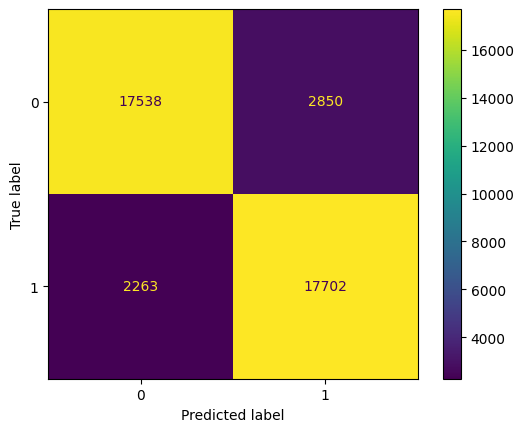

In [65]:
ConfusionMatrixDisplay(confusion_matrix(best_model.predict(X_test), y_test)).plot()

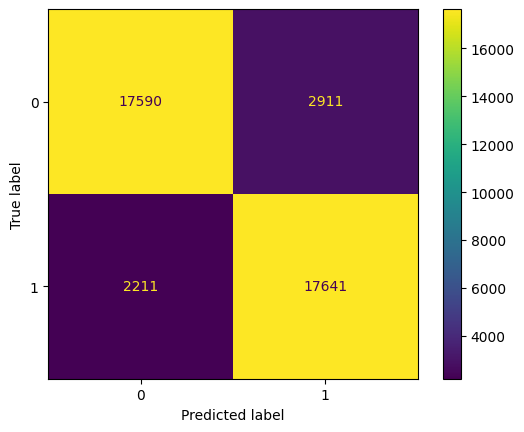

In [64]:
ConfusionMatrixDisplay(confusion_matrix(best_model_2.predict(X_test), y_test)).plot()

In [88]:
joblib.dump(model_1, '../models/LogReg.joblib')
joblib.dump(model_2, '../models/LinearSVC.joblib')

with open('../models/LogReg.pkl', 'wb') as f:  
    pickle.dump(model_1, f) 
    
with open('../models/LinearSVC.pkl', 'wb') as f:  
    pickle.dump(model_2, f) 

In [89]:
logreg = joblib.load('../models/LogReg.joblib')
print(f'f1_score для классического ML: {f1_score(logreg.predict(X_test), y_test)}')

f1_score для классического ML: 0.8747903305377405


# **Предобученная нейросеть**

В данном параграфе была использована модель rubert-tiny2 предобученная для определения тональности текстов с сайта HuggingFace: https://huggingface.co/seara/rubert-tiny2-russian-sentiment

In [ ]:
!pip install transformers evaluate accelerate -q

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import pipeline, set_seed
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader
from datasets import DatasetDict

In [ ]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset})

In [ ]:
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

test_dataset = Dataset.from_pandas(test_df)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-russian-sentiment")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-russian-sentiment", num_labels=3).to(device)
if tokenizer.pad_token_id >= model.config.vocab_size:
    model.resize_token_embeddings(len(tokenizer))

def tokenize_function(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
    tokenized['labels'] = examples['label']
    return tokenized

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

In [ ]:
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.remove_columns(['text'])
test_dataloader = DataLoader(tokenized_test, batch_size=32, collate_fn=data_collator)

In [ ]:
model.eval()
all_logits = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['idx', '__index_level_0__']}
        outputs = model(**batch)
        logits = outputs.logits
        all_logits.append(logits.cpu())

all_logits = torch.cat(all_logits, dim=0)

predicted_labels = torch.argmax(all_logits, dim=1).numpy()

In [ ]:
print(f'macro f-score до файнтюнинга модели: {f1_score(predicted_labels, y_test, average="macro")}')

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=1000,
    logging_dir="./logs",
    report_to="none",
    disable_tqdm=False,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation']
)

In [ ]:
trainer.train()

In [ ]:
model.eval()
all_logits = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['idx', '__index_level_0__']}
        outputs = model(**batch)
        logits = outputs.logits
        all_logits.append(logits.cpu())

all_logits = torch.cat(all_logits, dim=0)

predicted_labels = torch.argmax(all_logits, dim=1).numpy()

In [ ]:
print(f'macro f-score после файнтюнинга модели: {f1_score(predicted_labels, y_test, average="macro")}')

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(predicted_labels, y_test)).plot()